In [1]:
"""
Imports
"""
import json
import numpy as np
import pandas as pd

import sys
rootPath = '../../'
sys.path.insert(0, rootPath+'Architecture/')
from groundTruth import GroundTruth
from statistics import Statistics
from dataManagement import Scaler
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt

In [2]:
def get_features_node(node, rootPath):
    features_node = json.loads(open(rootPath+'features_node.json').read())
    features_to_use = features_node[node]['DataPlane']+features_node[node]['ControlPlane']
    features_to_use = features_to_use+['time']
    return features_to_use

In [3]:
"""
Load configuration
"""
dataset = 'BGP_testbed_5'
config = json.loads(open(rootPath+'configuration.json').read())['datasets'][dataset]

config_features = json.loads(open(rootPath+'features_node.json').read())

In [4]:
epsilon = 9
min_samples = 3
window = 80
scaler_type = 'StandardScaler'


node = 'leaf3'
features_node = get_features_node(node, rootPath)
df = pd.read_csv(rootPath + config['directory']+node+config['filename'],
                 low_memory=False, dtype='float64')\
        .dropna()
df = df[10:]
df = df[features_node]

times = df['time']//1e9
times = times.astype('int')
df.drop(['time'], axis=1, inplace=True)

scaler = Scaler(scaler_type)
dfNormalized = scaler.normalize(df)
print('boh: {}'.format(df.shape))

boh: (1438, 54)


In [5]:
def get_cluster_number(samples):
    
    normal_clusters_num = None
    anomalous_clusters_num = None
    
    uniques = np.unique(samples)
    if -1 in uniques:
        anomalous_clusters_num = 1
        normal_clusters_num = len(uniques) - 1
    else:
        anomalous_clusters_num = 0
        normal_clusters_num = len(uniques)
        
    return normal_clusters_num, anomalous_clusters_num

def get_center_radius(samples):
    N = samples.shape[1]
    size = samples.shape[0]
    LS = np.zeros(N)
    SS = np.zeros(N)
    
    for sample in samples:
        LS += np.array(sample)
        SS += np.power(np.array(sample),2)
        
    center = np.divide(LS, N)
    
    LSd = np.power(center, 2)
    SSd = np.divide(SS, N)
    
    radius = np.nanmax(np.sqrt(SSd)-LSd)
    
    return center, radius, size    

def get_cluster_characteristics(samples, labels):
    
    uniques = np.unique(labels)
    if -1 in uniques:
        anomalous_clusters_num = 1
        normal_clusters_num = len(uniques) - 1
    else:
        anomalous_clusters_num = 0
        normal_clusters_num = len(uniques)    
        
    clusters = []
    
    for unique in uniques:
        if unique != -1:
            current_samples = samples.iloc[labels==unique]
            center, radius, N = get_center_radius(current_samples.values)
            clusters.append((unique, center, radius, N))
            
    return clusters

In [6]:
history = []
normal_clusters = []
anomalous_clusters = []
cluster_characteristics = []

output_labels = []

samples = dfNormalized[:window]
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(samples)
history.append(list(db.labels_))
output_labels.append(db.labels_[-1])

normal_clusters_number, anomalous_clusters_number = get_cluster_number(db.labels_)

normal_clusters.append(normal_clusters_number)
anomalous_clusters.append(anomalous_clusters_number)
cluster_characteristics.append(get_cluster_characteristics(samples, db.labels_))

for index in range(dfNormalized.shape[0]+1):

    if index > window:
        samples = dfNormalized.iloc[index-window:index]
        db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(samples)
        history.append(list(db.labels_))
        output_labels.append(db.labels_[-1])
        normal_clusters_number, anomalous_clusters_number = get_cluster_number(db.labels_)
        
        normal_clusters.append(normal_clusters_number)
        anomalous_clusters.append(anomalous_clusters_number)
        cluster_characteristics.append(get_cluster_characteristics(samples, db.labels_))

In [7]:
indexes = []
labels = []
data = []

for index, element in enumerate(cluster_characteristics[:300]):
    for clusters in element:
        data.append(clusters[1])
        indexes.append(index)
        labels.append(clusters[0])
        

In [8]:
pca = PCA(n_components=2)
pca_centers = pd.DataFrame(pca.fit_transform(data))
print('1st: {}'.format(pca.explained_variance_ratio_[0]))
print('2nd: {}'.format(pca.explained_variance_ratio_[1]))
print('Sum: {}'.format(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]))

1st: 0.7210032981586569
2nd: 0.22057685444721772
Sum: 0.9415801526058747


In [9]:
pca_centers['labels'] = labels
pca_centers['indexes'] = indexes

In [10]:
import pickle

for variable, variable_name in [(normal_clusters, 'normal_clusters'),
                                (anomalous_clusters, 'anomalous_clusters'),
                               (cluster_characteristics, 'cluster_characteristics'),
                               (pca_centers, 'pca_centers'),
                               (output_labels, 'output_labels'),
                                (labels, 'labels')
                               ]:

    with open('wDBScan_variables/wDBScan_'+variable_name+'.pickle', 'wb') as f:
        pickle.dump(variable, f)

In [11]:
from matplotlib.ticker import MaxNLocator

def plot_vertical_event(axs, events):
    for ax in axs:
        for event_index in events:
            ax.axvline(x=event_index, linestyle='--', color='k')
            
def plot_normal_vs_outlier_cluster_evolution(ax):
    ax.plot(np.array(range(len(normal_clusters[:350])))+50,
        normal_clusters[:350],
                color=normal_color,
                linestyle='-',
                linewidth=2,
                label='normal'
              )

    ax.plot(np.array(range(len(normal_clusters[:350])))+50,
        anomalous_clusters[:350],
                color=anomalous_color,
                            linestyle='-.',
                            linewidth=2,
                            label='anomalous'
              )    
    ax.set_ylabel('#cluster', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)
    ax.legend()    
    
def plot_radius(ax):    
    
    for index, element in enumerate(cluster_characteristics[:350]):
        for clusters in element:
            ax.scatter(index+50, clusters[2], s=10, color=cluster_id_color[clusters[0]], marker=cluster_id_marker[clusters[0]])

    ax.set_ylabel('radius', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)   
    
def plot_weight(ax):    
    
    for index, element in enumerate(cluster_characteristics[:350]):
        for clusters in element:
            ax.scatter(index+50, clusters[3], s=10, color=cluster_id_color[clusters[0]], marker=cluster_id_marker[clusters[0]])

    ax.axhline(y=3, color='k', linestyle='--')
            
    ax.set_ylabel('weight', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)       
    
def plot_first_center(ax):
    for cluster_id in pca_centers['labels'].unique():
        to_plot = pca_centers[pca_centers['labels']==cluster_id]
        ax.scatter(to_plot['indexes']+50, to_plot[0], s=10, color=cluster_id_color[cluster_id], marker=cluster_id_marker[cluster_id])
    ax.set_ylabel('$1^{st}$ c. center', fontsize=y_label_size, labelpad=-13)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)    
        
def plot_second_center(ax):
    for cluster_id in pca_centers['labels'].unique():
        to_plot = pca_centers[pca_centers['labels']==cluster_id]
        ax.scatter(to_plot['indexes']+50, to_plot[1], s=10, color=cluster_id_color[cluster_id], marker=cluster_id_marker[cluster_id])        
        
    ax.set_ylabel('$2^{nd}$ c. center', fontsize=y_label_size, labelpad=15)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)   
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
def plot_assigned_labels(ax):
    local_labels = pd.DataFrame(output_labels[:350])
    
    ax.scatter(local_labels[local_labels[0]>=0].index+50,
               local_labels[local_labels[0]>=0][0],
               color=normal_color,
               s=4
    )
    
    ax.scatter(local_labels[local_labels[0]<0].index+50,
               np.ones(len(local_labels[local_labels[0]<0].index+50))*-1,
               color=anomalous_color,
               s=4
    )    
    ax.set_ylabel('labels', fontsize=y_label_size)
    ax.tick_params(axis='both', which='major', labelsize=y_label_tick_size)
    ax.tick_params(axis='both', which='minor', labelsize=y_label_tick_size)    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))


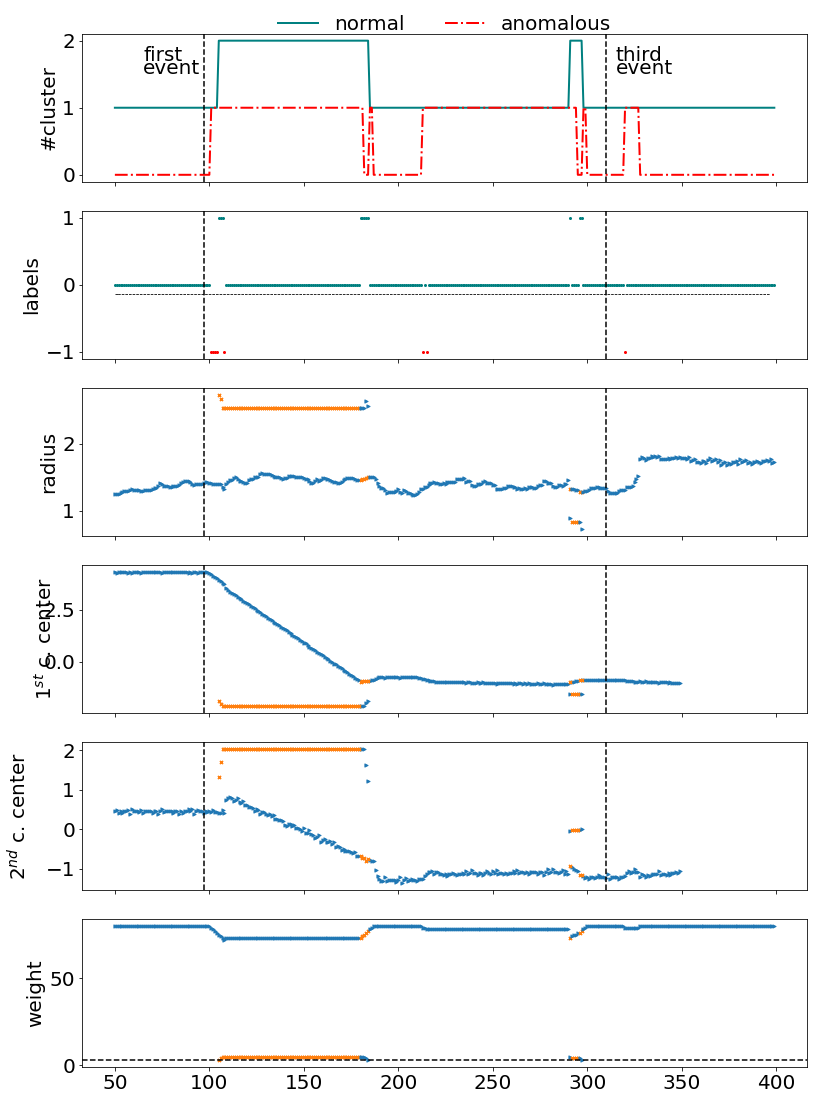

In [12]:
normal_color = 'teal'
anomalous_color = 'red'

y_label_size = 20
y_label_tick_size = 20
text_size = 20

cluster_id_color = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: 'green',
    3: 'orange'
}

cluster_id_marker = {
    0 : '>',
    1: 'x',
    2: '<'
}

fig, ax = plt.subplots(6, figsize=(13,19), sharex=True)
plot_normal_vs_outlier_cluster_evolution(ax[0])
plot_assigned_labels(ax[1])
plot_radius(ax[2])
plot_first_center(ax[3])
plot_second_center(ax[4])
plot_weight(ax[5])


plot_vertical_event([ax[0], ax[1], ax[2], ax[3], ax[4]], [97, 310])

ax[0].text(65, 1.7, 'first', fontsize=text_size)
ax[0].text(65, 1.5, 'event', fontsize=text_size)

ax[0].text(315, 1.7, 'third', fontsize=text_size)
ax[0].text(315, 1.5, 'event', fontsize=text_size)

ax[1].text(50, -0.18, '-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=False, fontsize=20, frameon=False)